In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func
import numpy as np
import pandas as pd
import datetime as dt

ImportError: C extension: No module named 'pandas._libs.tslib' not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext --inplace --force' to build the C extensions first.

# Reflect Tables into SQLAlchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [51]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [52]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [53]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [54]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [55]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

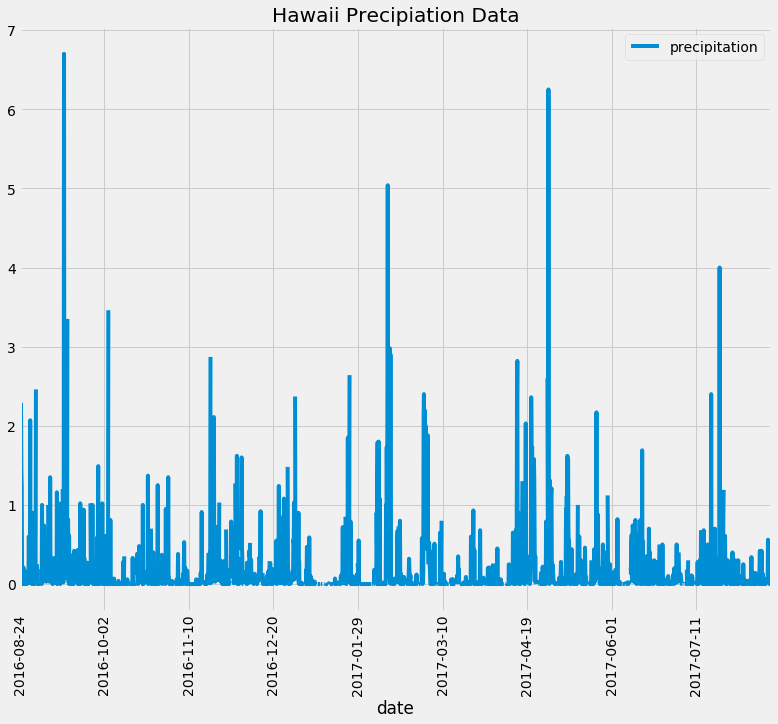

In [112]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp = session.query(Measurement.date, Measurement.prcp).all()
prcp = pd.DataFrame(prcp, columns=['date', 'precipitation']).sort_values('date')

last_data_point = prcp['date'].iloc[[-1][0]]
last_data_point = dt.datetime.strptime(last_data_point, "%Y-%m-%d").date()
year_from_last = last_data_point - dt.timedelta(days=365)

prcp_filtered = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_from_last).all()
prcp_df = pd.DataFrame(prcp_filtered, columns=['date', 'precipitation']).sort_values('date')
prcp_df = prcp_df.set_index('date')

prcp_df.plot(title="Hawaii Precipiation Data", figsize=(12, 10), rot=90)

In [113]:
# Use Pandas to calulate the summary statistics for the precipitation data
summ = prcp_df.describe()
summ

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [114]:
# Design a query to show how many stations are available in this dataset
station_count = session.query(Station.station).count()
station_count

9

In [115]:
# What are the most active stations in descending order?
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station) \
                            .order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [116]:
# Using the station id from the previous query, calculate min, avg, max for the most active station.
most_active = station_activity[0][0]
stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                    .filter(Measurement.station == most_active).all()
print(f"{most_active}: min, avg, max = {stats}")

USC00519281: min, avg, max = [(54.0, 85.0, 71.66378066378067)]


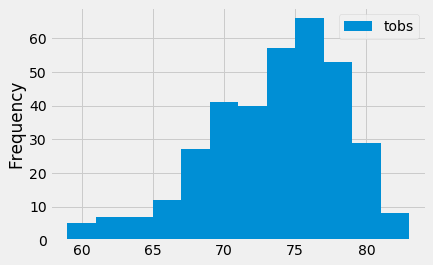

In [126]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_obs_station = session.query(Measurement.tobs).filter(Measurement.station == most_active) \
                .filter(Measurement.date.between(year_from_last, last_data_point)).all()

tobs_df = pd.DataFrame(most_obs_station, columns=['tobs'])
tobs_df.plot(kind='hist', bins=12)

In [127]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(year_from_last, last_data_point):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date.between(year_from_last, last_data_point)).all()

# function usage example
calc_temps('2012-02-28', '2012-03-05')

[(62.0, 69.57142857142857, 74.0)]

In [128]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-03-15'
trip_end = '2016-03-29'
tstats = calc_temps(trip_start, trip_end)
tmin = tstats[0][0]
tavg = tstats[0][1]
tmax = tstats[0][2]
tstats

[(63.0, 70.8586956521739, 82.0)]

(-1, 1)

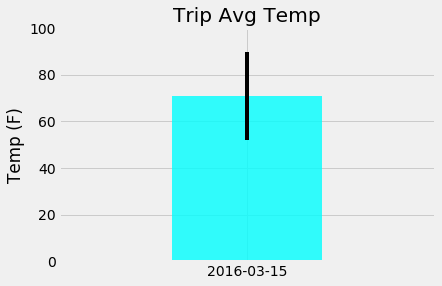

In [166]:
# Plot the results from your previous query as a bar chart. 
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax-tmin
# Use the average temperature for the y value
plt.bar(trip_start, tavg, yerr=yerr, color='cyan', alpha = 0.8)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.xlim(-1, 1)